In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import utils.utils as utils
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
from utils.utils_models import NaiveRollingMean, NaiveLag
from sklearn.model_selection import TimeSeriesSplit

sns.set_theme(style="darkgrid")

In [2]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)
df_kaggle = utils_preprocessing.preprocess_columns(df_kaggle)
# Resample weekly for each sku
# utils.looks_for_missing_dates(df_kaggle)
df_kaggle = utils_preprocessing.fill_in_missing_dates(df_kaggle)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_preprocessing.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_ranges = df.groupby(group_col)[date_col].agg(["min", "max"]).reset_index()


In [3]:
# Interpolation and fill-in function
def interpolate_sku(group):
    group = group.sort_values(by='date')
    group = group.set_index('date')  
    group['sales_units'] = group['sales_units'].interpolate(method='time')
    group['inventory_units'] = group['inventory_units'].interpolate(method='time')
    return group.reset_index()

df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(interpolate_sku)

# Generate features
df_kaggle = utils_features.features_time_related(df_kaggle)
df_kaggle = utils_features.features_lag(df=df_kaggle, col='inventory_units', lags=[13])
df_kaggle = utils_features.features_lag(df=df_kaggle, col='sales_units', lags=[13, 14, 15])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='inventory_units', window_sizes=[4, 8])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='sales_units', window_sizes=[4, 8])

df_kaggle = df_kaggle.rename(columns={'inventory_units': 'y'}).set_index('date').sort_index()

df_kaggle = df_kaggle.dropna()

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_93719/1975600604.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(interpolate_sku)


### Validate the last 13*2 weeks

In [4]:
fc_model_rolling = NaiveRollingMean(hyperparameters={'window': 4})
results_cv = fc_model_rolling.cross_validate(df_kaggle, n_splits=2)

Model evaluation completed. RMSE: 55.812
Model evaluation completed. RMSE: 58.36
Average RMSE from cross-validation: 57.0860


/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sku")[self.column]
/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sku")[self.column]


In [5]:
fc_model_lag = NaiveLag(hyperparameters={'lag': 13})
results_cv = fc_model_lag.cross_validate(df_kaggle, n_splits=2)

Model evaluation completed. RMSE: 56.995
Model evaluation completed. RMSE: 60.858
Average RMSE from cross-validation: 58.9265


/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sku")[self.column]
/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sku")[self.column]


### Plot results for the last 13 weeks

In [6]:
X_train, X_test, y_train, y_test = utils.train_test_split(df_kaggle, forecasting_horizon=13, target_col="y")

In [7]:
fc_model_rolling = NaiveRollingMean(hyperparameters={'window': 4})
fc_model_rolling.train(X_train, y_train)

fc_model_lag = NaiveLag(hyperparameters={'lag': 13})
fc_model_lag.train(X_train, y_train)

In [8]:
df_preds_rolling = utils.predict_last_13_weeks(df_kaggle, fc_model_rolling)
df_preds_lag = utils.predict_last_13_weeks(df_kaggle, fc_model_lag)

df_final = df_kaggle.merge(df_preds_rolling.reset_index(), on=['date', 'sku'], how='left')

/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sku")[self.column]
/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sku")[self.column]


In [9]:
temp = df_preds_lag.reset_index().merge(df_preds_rolling, on=['date', 'sku'], suffixes=['_lag', '_rolling'])
df_final = df_kaggle.merge(temp, on=['date', 'sku'], how='left')[['date', 'sku', 'y', 'y_pred_lag', 'y_pred_rolling']]
vline_dates = [df_final['date'].max() - pd.DateOffset(weeks=13)]

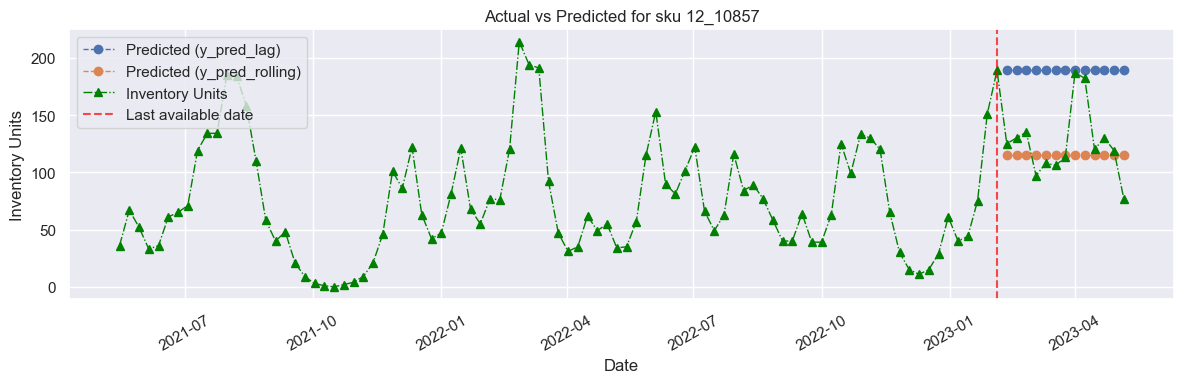

In [21]:
utils_plots.plot_real_vs_predicted(df_final, sku='12_10857', pred_columns=['y_pred_lag', 'y_pred_rolling'], vline_dates=vline_dates)

In [22]:
num_select = 4
#list_skus = np.random.choice(df_preds_rolling['sku'].unique(), size=num_select, replace=False) # Random
#list_skus = df_preds_rolling["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
list_skus = df_preds_rolling["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

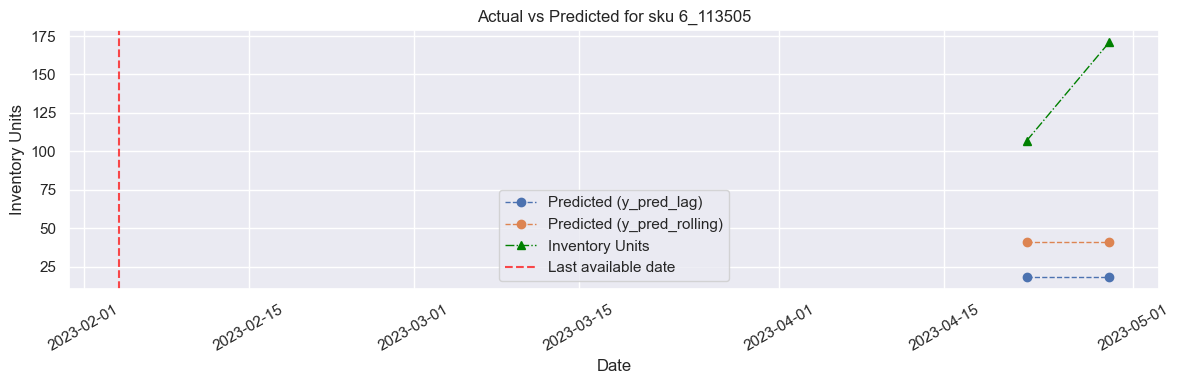

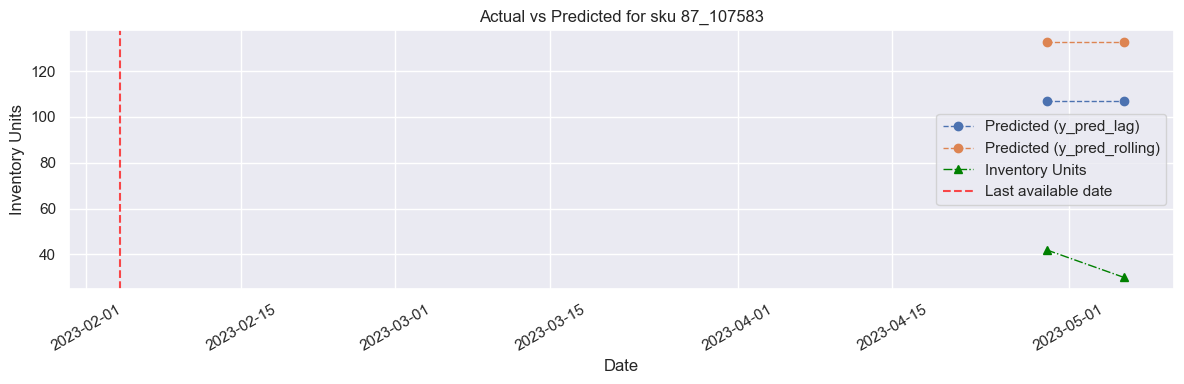

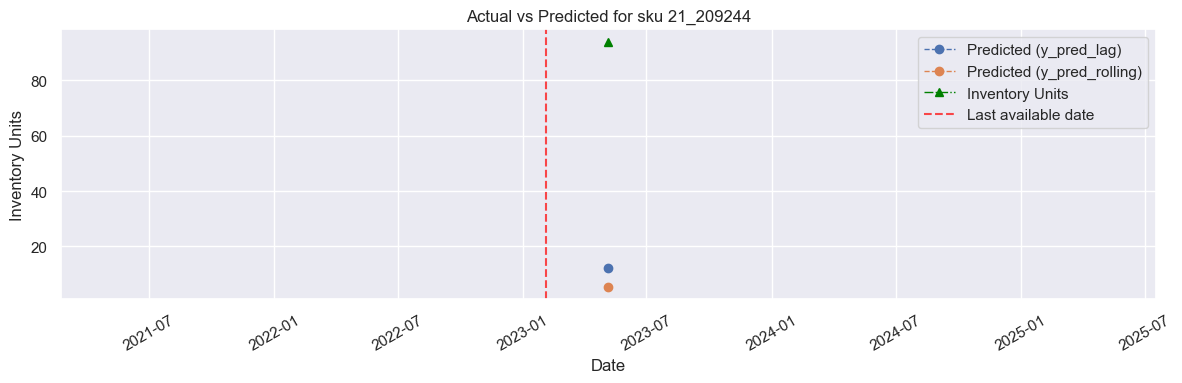

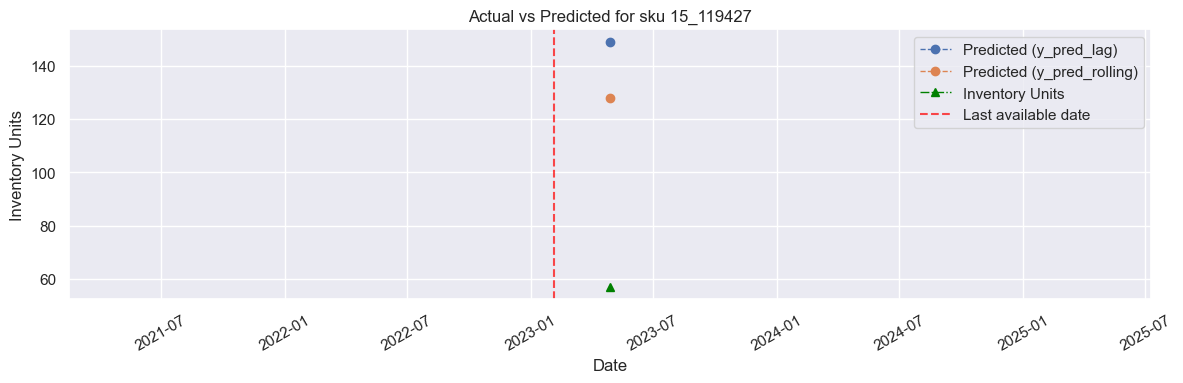

In [23]:
date_present = df_final['date'].max() - pd.DateOffset(weeks=13)
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_final, sku, pred_columns=['y_pred_lag', 'y_pred_rolling'], vline_dates=[date_present])